In [1]:
# Ignoring warning for better presentation
options(warn=-1)

In [3]:
# import
library(rpart)
library(rpart.plot)
library(caret)
library(Metrics)
library(ModelMetrics)

In [4]:
# reading data file ~ credit.csv 
# taken from https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29

# credit.csv is composed of qualitative and quantitative variables.
# For this exercise we will focus on the following variables only, namely -
# months_loan_duration: colnumber - 2
# percent_of_income: colnumber - 8
# years_at_residence: colnumber - 9
# age - 10
# default - 17

cols <- rep('NULL', 17)
cols[c(2, 8, 9, 10, 17)] <- NA

creditsub <- read.csv(file = '/home/dell/R_programming/case studies/trees/machinelearning-R/credit.csv', 
                      colClasses = cols,
                      header = T)

# Let's take a look at the dataframe
head(creditsub)

months_loan_duration,percent_of_income,years_at_residence,age,default
6,4,4,67,no
48,2,2,22,yes
12,2,3,49,no
42,2,4,45,no
24,3,4,53,yes
36,2,4,35,no


In [5]:
# Let's check out the structure of the df
str(creditsub)

'data.frame':	1000 obs. of  5 variables:
 $ months_loan_duration: int  6 48 12 42 24 36 24 36 12 30 ...
 $ percent_of_income   : int  4 2 2 2 3 2 3 2 2 4 ...
 $ years_at_residence  : int  4 2 3 4 4 4 4 2 4 2 ...
 $ age                 : int  67 22 49 45 53 35 53 35 61 28 ...
 $ default             : Factor w/ 2 levels "no","yes": 1 2 1 1 2 1 1 1 1 2 ...


In [6]:
# Let's split the data into train and test

# Setting seed for reproducible train and test partitions
set.seed(123)

smp_size <- floor(0.75 * nrow(creditsub))

train_ind <- sample(seq_len(nrow(creditsub)), size = smp_size)

credit_train <- creditsub[train_ind, ]

credit_test <- creditsub[-train_ind, ]

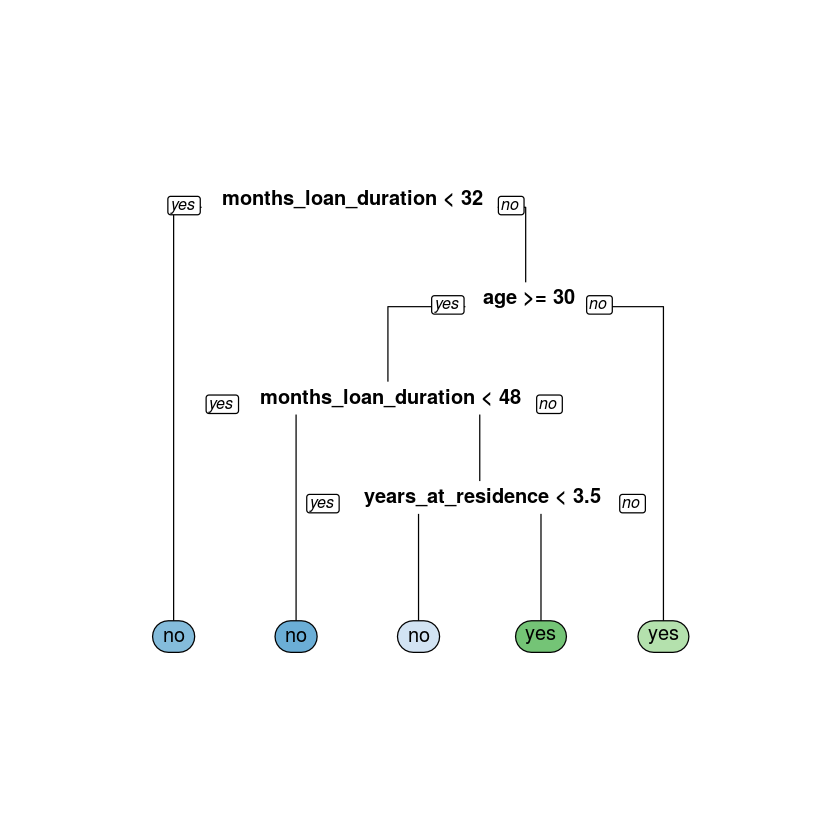

In [7]:
# Let's create a binary classification tree model
# and train it with training df created above

# Here we are using all the variables to determine 'default'
# hence the forumla is default(response variable) vs ., where (.) signifies
# all other variables(predictor variables) apart from default
credit_model <- rpart(
                    formula = default ~ ., 
                    data = credit_train, 
                    method = "class"
                    )

# Display the results
rpart.plot(x = credit_model, yesno = 2, type = 0, extra = 0)

# As you can see from the figure, trees are easy to 
# interpret, visualize and understand
# Tree based models don't need normalization or special 
# encoding of categorical variables

In [8]:
# So now we generate the predicted results 
# and compare it with credit_test actual values

# Let's predict the credit_test but use type='prob'
# to get the probabilities of each class rather than
# the class itself

class_prediction <- predict(object = credit_model,
                        newdata = credit_test,   
                        type = "prob")

head(class_prediction)
tail(class_prediction)

,no,yes
3,0.7377850,0.2622150
4,0.7735849,0.2264151
10,0.7377850,0.2622150
11,0.7377850,0.2622150
14,0.7377850,0.2622150
22,0.7377850,0.2622150


,no,yes
978,0.737785,0.262215
985,0.737785,0.262215
986,0.737785,0.262215
988,0.737785,0.262215
991,0.737785,0.262215
999,0.326087,0.673913


In [9]:
# Let's now assign a class rather than probability
class_prediction <- predict(object = credit_model,
                        newdata = credit_test,   
                        type = "class")

head(class_prediction)
tail(class_prediction)

3  4 10 11 14 22 
no no no no no no 
Levels: no yes

978 985 986 988 991 999 
 no  no  no  no  no yes 
Levels: no yes

In [10]:
# There are various evaluation metrics to evaluate
# our binary classification tree based model.
# However, let's just check our model's confusion 
# matrix to get a better sense of our model.

# Calculate the confusion matrix for the test set
caret::confusionMatrix(data = class_prediction,       
                reference = credit_test$default)

# That outputs a whole bunch of values. Let's just
# look at accuracy and the confusion matrix.
# Accuracy of 71.2% is fair but not that impressive.
# Upon checking the confusion matrix, we realize that
# the model is not good with predicting the default
# when it is actually a default.

Confusion Matrix and Statistics

          Reference
Prediction  no yes
       no  168  65
       yes   7  10
                                          
               Accuracy : 0.712           
                 95% CI : (0.6516, 0.7673)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.3681          
                                          
                  Kappa : 0.1198          
 Mcnemar's Test P-Value : 1.849e-11       
                                          
            Sensitivity : 0.9600          
            Specificity : 0.1333          
         Pos Pred Value : 0.7210          
         Neg Pred Value : 0.5882          
             Prevalence : 0.7000          
         Detection Rate : 0.6720          
   Detection Prevalence : 0.9320          
      Balanced Accuracy : 0.5467          
                                          
       'Positive' Class : no              
                                          

In [11]:
# Since we are not convinced with our results, what else
# could be done? Here if we look at the training model
# step then we will realize that we are using methods = 'class'
# which uses 'gini' as the default splitting index. 
# We should see if there is any difference if we change the 
# splitting index. 

# Let's train our model with gini splitting index vs information
# splitting index

# Train a gini-based model
credit_model1 <- rpart(formula = default ~ ., 
                       data = credit_train, 
                       method = "class",
                       parms = list(split = 'gini'))

# Train an information-based model
credit_model2 <- rpart(formula = default ~ ., 
                       data = credit_train, 
                       method = "class",
                       parms = list(split = 'information'))

# Generating predictions on the validation set using the gini model
pred1 <- predict(object = credit_model1, 
             newdata = credit_test,
             type = "class")    

# Generating predictions on the validation set using the information model
pred2 <- predict(object = credit_model2, 
             newdata = credit_test,
             type = "class")
# Comparing classification error which is the fraction of incorrectly
# classified instances. This implies the lower the score the better
# the model. We use a function ce from ModelMetrics package.

ce(actual = credit_test$default, 
   predicted = pred1)
ce(actual = credit_test$default, 
   predicted = pred2)

[1] 0.288

[1] 0.288

In [12]:
# As seen parameter tuning is of no help in this case.
# We need to look at some other approach - Bagged Trees. Bagged Trees
# are discussed in another notebook. Please check in the repo.

In [14]:
# Let's see another dataset. However, this time
# we will deal with a regression tree based model. 

# reading data file ~ grade.csv 
# taken from https://archive.ics.uci.edu/ml/datasets/Student+Performance

# grade.csv is composed of qualitative and quantitative variables.
# For this exercise we will focus on the following variables only, namely -
# sex [m/f], age, address, studytime (weekly study time), 
# schoolsup (extra educational support) [yes/no],
# famsup (family educational support) [yes/no],
# paid (extra paid classes within the course subject) [y/n] and absences

# The response is final_grade (numeric: from 0 to 20, output target).

grade <- read.csv(file = '/home/dell/R_programming/case studies/trees/machinelearning-R/grade.csv', 
                      header = T)

# Let's take a look at the dataframe
head(grade)

final_grade,age,address,studytime,schoolsup,famsup,paid,absences
3.0,18,U,2,yes,no,no,6
3.0,17,U,2,no,yes,no,4
5.0,15,U,2,yes,no,yes,10
7.5,15,U,3,no,yes,yes,2
5.0,16,U,2,no,yes,yes,4
7.5,16,U,2,no,yes,yes,10


In [15]:
str(grade)

'data.frame':	395 obs. of  8 variables:
 $ final_grade: num  3 3 5 7.5 5 7.5 5.5 3 9.5 7.5 ...
 $ age        : int  18 17 15 15 16 16 16 17 15 15 ...
 $ address    : Factor w/ 2 levels "R","U": 2 2 2 2 2 2 2 2 2 2 ...
 $ studytime  : int  2 2 2 3 2 2 2 2 2 2 ...
 $ schoolsup  : Factor w/ 2 levels "no","yes": 2 1 2 1 1 1 1 2 1 1 ...
 $ famsup     : Factor w/ 2 levels "no","yes": 1 2 1 2 2 2 1 2 2 2 ...
 $ paid       : Factor w/ 2 levels "no","yes": 1 1 2 2 2 2 1 1 2 2 ...
 $ absences   : int  6 4 10 2 4 10 0 6 0 0 ...


In [16]:
# Let's divide the df into train, test and validation
# Validation is for tuning hyperparameters.

set.seed(1)
assignment <- sample(1:3, size = nrow(grade), prob = c(0.7, 0.15, 0.15), replace = TRUE)

# Creating a train, validation and tests from the original data frame 
grade_train <- grade[assignment == 1, ]    # subset the grade data frame to training indices only
grade_valid <- grade[assignment == 2, ]  # subset the grade data frame to validation indices only
grade_test <- grade[assignment == 3, ]   # subset the grade data frame to test indices only

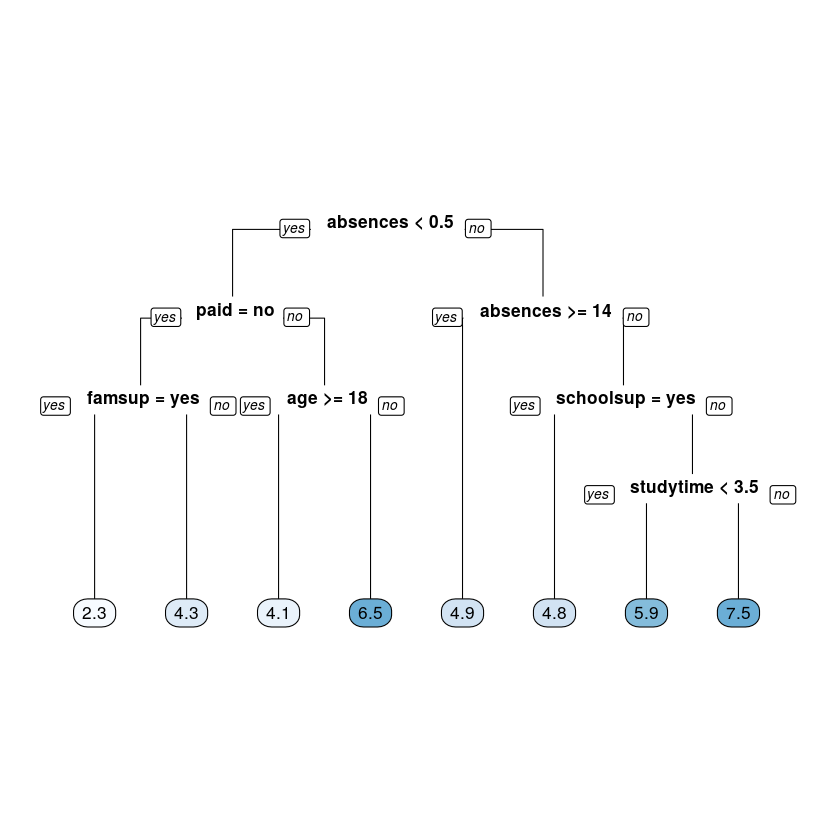

In [17]:
# Train the model
grade_model <- rpart(formula = final_grade ~ ., 
                     data = grade_train, 
                     method = "anova")

# Plot the tree model
rpart.plot(x = grade_model, yesno = 2, type = 0, extra = 0)

In [18]:
# Let's evaulate the model

# Generating predictions on a test set
pred <- predict(object = grade_model,
                newdata = grade_test)

# RMSE
rmse(actual = grade_test$final_grade, 
     predicted = pred)

[1] 2.278249

In [19]:
# So we are done evaluating the model.
# But we haven't used validation set yet. Then
# let's see how can we use that. In all the 
# models there are some knobs i.e. hyperparameters
# which improves the model. Let's tune them for
# tree based regression model. 

# There are three main knobs that are helpful with
# tree based models, namely -
# 1. minsplit: minimum number of datapoints required to attempt a split. Default 20.
# 2. cp: complexity parameter. Default .01.
# 3. maxdepth: depth of a decision tree. Default 30.

# Let's look at CP a little bit deeper. The smaller the value of CP
# the more complex is the model. When creating the model, rpart creates
# a table with different values of CP along with their effect on the model.

# Printing the CP Table
print(grade_model$cptable)

          CP nsplit rel error    xerror       xstd
1 0.06839852      0 1.0000000 1.0080595 0.09215642
2 0.06726713      1 0.9316015 1.0920667 0.09543723
3 0.03462630      2 0.8643344 0.9969520 0.08632297
4 0.02508343      3 0.8297080 0.9291298 0.08571411
5 0.01995676      4 0.8046246 0.9357838 0.08560120
6 0.01817661      5 0.7846679 0.9337462 0.08087153
7 0.01203879      6 0.7664912 0.9092646 0.07982862
8 0.01000000      7 0.7544525 0.9407895 0.08399125


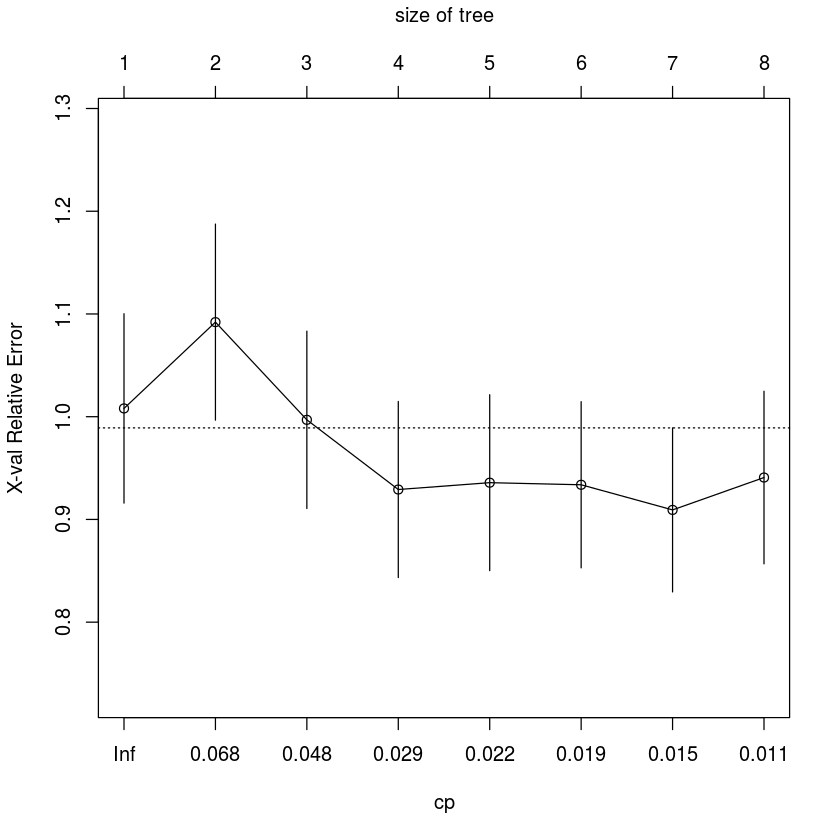

In [20]:

# Let's plot the CP Table as well# Let's  
plotcp(grade_model)

In [21]:
# Based on the table, the minimum value of xerror is at
# cp of 0.01203879. But let's do it programmatically.

opt_index <- which.min(grade_model$cptable[, "xerror"])
(cp_opt <- grade_model$cptable[opt_index, "CP"])

[1] 0.01203879

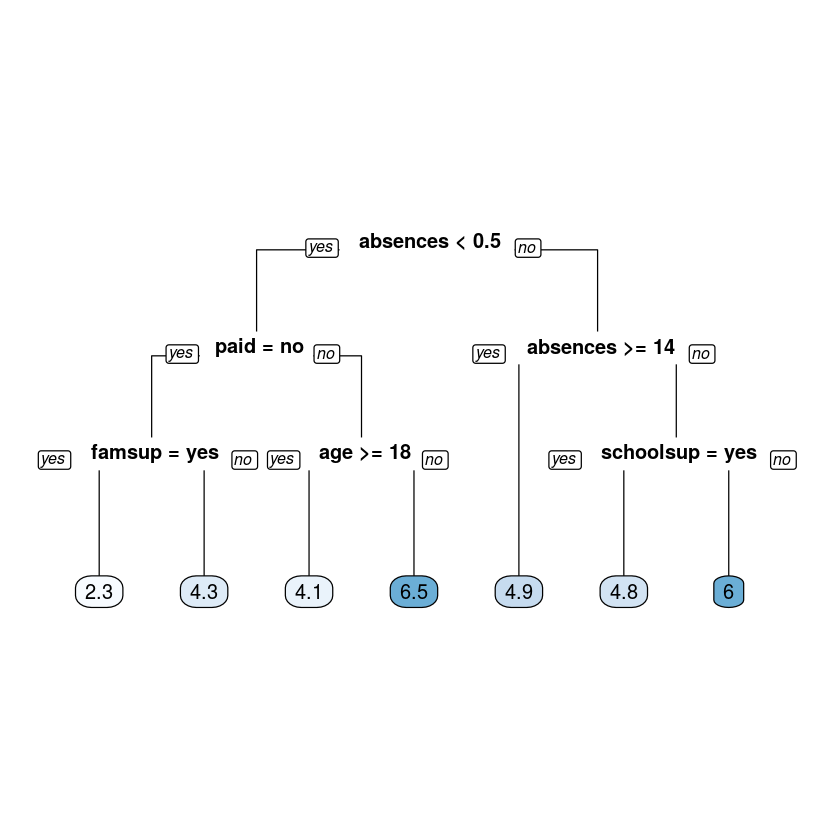

In [22]:
# Prune the model (to optimized cp value)
grade_model_opt <- prune(tree = grade_model, 
                         cp = cp_opt)
                          
# Plot the optimized model
rpart.plot(x = grade_model_opt, yesno = 2, type = 0, extra = 0)

In [23]:
# Once we have determined the best CP we can look 
# at the other two Hyperparameters - minsplit and maxdepth.
# Searching for correct values minsplit and maxdepth is found
# by iterating through all the possible combinations of 
# minsplit and maxdepth

# Establishing a list of possible values for minsplit and maxdepth
minsplit <- seq(1, 4, 1)
maxdepth <- seq(1, 6, 1)

# Create a data frame containing all combinations 
hyper_grid <- expand.grid(minsplit = minsplit, maxdepth = maxdepth)

# Check out the grid
head(hyper_grid)

minsplit,maxdepth
1,1
2,1
3,1
4,1
1,2
2,2


In [24]:
# Number of potential models in the grid
num_models <- nrow(hyper_grid)

# Making an empty list to store models
grade_models <- list()

# Let's write a loop over the rows of hyper_grid to train the grid of models
for (i in 1:num_models) {

    # Get minsplit, maxdepth values at row i
    minsplit <- hyper_grid$minsplit[i]
    maxdepth <- hyper_grid$maxdepth[i]

    # Train a model and store in the list
    grade_models[[i]] <- rpart(formula = final_grade ~ ., 
                               data = grade_train, 
                               method = "anova",
                               minsplit = minsplit,
                               maxdepth = maxdepth,
                               cp = cp_opt)
}
# Let's evaluate the grid. Earlier we set aside
# validation set for this purpose. 

num_models <- length(grade_models)

# Making an empty vector to store RMSE values
rmse_values <- c()

# Okay! So that has been a lot of work. We are almost
# going to eat the fruit of our efforts. Just a few 
# more steps.

# Looping over the models to compute validation RMSE
for (i in 1:num_models) {

    # Retreive the i^th model from the list
    model <- grade_models[[i]]
    
    pred <- predict(object = model,
                    newdata = grade_valid)
    
    # Compute validation RMSE and add to the 
    rmse_values[i] <- rmse(actual = grade_valid$final_grade, 
                           predicted = pred)
}

# Identify the model with smallest validation set RMSE
best_model <- grade_models[[which.min(rmse_values)]]

# Let's have a look at the final chosen params
best_model$control

$minsplit
[1] 2

$minbucket
[1] 1

$cp
[1] 0.01203879

$maxcompete
[1] 4

$maxsurrogate
[1] 5

$usesurrogate
[1] 2

$surrogatestyle
[1] 0

$maxdepth
[1] 1

$xval
[1] 10

In [25]:
# Compute test set RMSE on best_model
pred <- predict(object = best_model,
                newdata = grade_test)

rmse(actual = grade_test$final_grade, 
     predicted = pred)

[1] 2.124109

In [26]:
# Damn! We have come a long way now. Earlier we had
# an RMSE score of 2.27824929805273 and now score of
# 2.12410938449928. That's an improvement of

100*abs(2.12410938449928 - 2.27824929805273)/2.27824929805273

# 6.76571759224051% 
# This much improvement will make you jump 1000s of position
# on any Kaggle Competition. It seems that the effort was worth it.

[1] 6.765718